# Implementation testing
### Comparison of our optimized model,<br>our regular model, model which uses PCA from sklearn and LBPH model

In [17]:
import numpy as np

from time import time
import random
import os

from sklearn.model_selection import train_test_split
from eigenfaces_model_optimised import EigenfacesModel as EigenfacesModelOptimized
from eigenfaces_model import EigenfacesModel
from eigenfaces_model_other import EigenfacesModel as EigenfacesModelOther
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score




In [18]:
FACES_PATH, FACES_TARGET_PATH = "pics/archive(1)/olivetti_faces.npy", "pics/archive(1)/olivetti_faces_target.npy"

faces = np.load(FACES_PATH)

faces_target = np.load(FACES_TARGET_PATH)


X = faces

y = faces_target

target_names = np.array(list({str(target) for target in y}))
n_classes = target_names.shape[0]



Split into a training set and a test and keep 20% of the data for testing.



In [19]:
def split_data(faces, faces_target, test_percentage, non_trained_person_count = 0):
    faces_dict = {}
    for i, img in zip(faces_target, faces):
        faces_dict[i] = faces_dict.get(i, []) + [img]
    

    faces_train = []
    faces_train_target = []
    faces_test = []
    faces_test_target = []

    labels_faces = list(faces_dict.items())
    for i in range(non_trained_person_count):
        faces_test.extend(labels_faces[i][1])
        faces_test_target.extend([-1] * len(labels_faces[i][1]))
        del faces_dict[i]
    print(faces_dict.keys())

    for person_id, person_faces in faces_dict.items():
        TEST_FACES_COUNT = int(len(person_faces) * test_percentage)
        TRAIN_FACES_COUNT = len(person_faces) - TEST_FACES_COUNT
        faces_test.extend(person_faces[:TEST_FACES_COUNT])
        faces_test_target.extend([person_id] * TEST_FACES_COUNT)
        faces_train.extend(person_faces[TEST_FACES_COUNT:])
        faces_train_target.extend([person_id] * TRAIN_FACES_COUNT)

    return np.array(faces_train), np.array(faces_train_target), np.array(faces_test), np.array(faces_test_target)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=43
)

print(f"{len(np.unique(y_train))}")
print(f"{y_train = }")

40
y_train = array([ 4,  9, 21, 29, 25,  6, 37,  2, 39, 38, 38,  4,  7, 11, 19, 14, 21,
       12,  3,  7, 26, 17, 13, 31, 16, 38, 29,  0, 37, 25, 11, 39, 27,  1,
       14, 13, 18,  5,  9, 23, 28,  6, 32,  1,  9, 11, 23, 18, 34,  4,  1,
       23, 28, 26, 14,  7,  7, 12, 10, 34, 27, 13,  3,  4,  0, 11, 15, 21,
       31,  5, 21,  2,  5, 31, 11, 29, 28, 34, 29,  8,  0, 12, 24, 14, 24,
       26, 11, 21,  9, 11,  5, 16,  6, 12, 17, 16, 39, 25, 35, 27, 10, 32,
       25, 28, 20, 23,  2, 29, 23, 35,  9, 15, 37, 23, 33, 18, 29,  0, 19,
        3, 13, 22,  6, 38,  5, 15, 22, 15,  3,  9, 37, 36, 16, 24, 24, 31,
       10,  8,  1, 24, 12,  0, 26, 35, 11, 15,  4, 13, 12, 27, 24, 15, 10,
       12,  7, 27,  9, 37, 18, 37, 17, 22, 25, 18,  7, 24,  4, 38, 20,  7,
       32, 16, 16,  2, 39, 31, 35, 14, 15, 29,  3,  8, 22,  4,  5, 30,  8,
       33, 19, 36, 20, 22, 12, 33, 30, 27,  9, 16, 15, 15, 33, 21, 28,  8,
       17, 39, 17,  0, 36, 33, 19, 26, 26,  0, 20, 28,  6, 20, 10, 27, 14,
       19,  

### Model using sklearn PCA implementation

In [21]:
time_started = time()
model2 = EigenfacesModelOther()
model2.train(X_train, y_train, 0.95)
time_taken_sklearn = round(time() - time_started, 2)
testing_metrics_sklearn = model2.test(X_test, y_test)
print("accuracy: {}, precision: {}, recall: {}, f1: {}".format(*testing_metrics_sklearn))

accuracy: 0.91, precision: 0.97, recall: 0.94, f1: 0.95


### Model which uses optimization for faster computation

In [22]:
time_started = time()
model_optimized = EigenfacesModelOptimized()

model_optimized.train(X_train, y_train, 0.95)
time_taken_optimized = round(time() - time_started, 2)
testing_metrics_optimized = model_optimized.test(X_test, y_test)
print("accuracy: {}, precision: {}, recall: {}, f1: {}".format(*testing_metrics_optimized))

accuracy: 0.81, precision: 0.89, recall: 0.9, f1: 0.9


### Our non-optimized model

In [23]:
time_started = time()
model = EigenfacesModel()

model.train(X_train, y_train, 0.95)
time_taken_regular = round(time() - time_started, 2)
testing_metrics_regular = model.test(X_test, y_test)
print("accuracy: {}, precision: {}, recall: {}, f1: {}".format(*testing_metrics_regular))

accuracy: 0.84, precision: 0.94, recall: 0.88, f1: 0.91


### LBPH

In [24]:
from cv2.face import LBPHFaceRecognizer_create

time_started = time()
recognizer = LBPHFaceRecognizer_create()

recognizer.train(X_train, y_train)
time_taken_lbph = round(time() - time_started, 2)

In [25]:
def test(recognizer, faces_test, face_test_labels):
    testing_results = {"False": {"positive": 0, "negative": 0}, "True": {"positive": 0, "negative": 0}}
    min_confidence = float("inf")
    for label, face in zip(face_test_labels, faces_test):
        pred, confidence = recognizer.predict(face)
        pred = (-1 if confidence > 120 else pred)
        min_confidence = min(confidence, min_confidence)
        # print(label, pred, confidence)
        true_prediction = label == pred
        face_in_dataset = pred != -1
        if face_in_dataset:
            testing_results[str(true_prediction)]["positive"] += 1
        else:
            testing_results[str(true_prediction)]["negative"] += 1
    # print(testing_results, min_confidence)
    total_correct = testing_results["True"]["positive"] + testing_results["True"]["negative"]
    total_incorrect = testing_results["False"]["positive"] + testing_results["False"]["negative"]
    accuracy = total_correct / (total_correct + total_incorrect)
    precision = testing_results["True"]["positive"] / (testing_results["True"]["positive"] + testing_results["False"]["positive"])
    recall = testing_results["True"]["positive"] / (testing_results["True"]["positive"] + testing_results["False"]["negative"])
    f1_score = 2 * precision * recall / (precision + recall)
    metrics = accuracy, precision, recall, f1_score
    return [round(metric, 2) for metric in metrics]

In [26]:
testing_metrics_lbph = test(recognizer, X_test, y_test)
print("accuracy: {}, precision: {}, recall: {}, f1: {}".format(*testing_metrics_lbph))


accuracy: 0.96, precision: 0.96, recall: 1.0, f1: 0.98


### Neural network

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

SIZE = 96

def resize_images(images, size=(SIZE, SIZE)):
    resized = []
    for img in images:
        img_resized = cv2.resize(img, size)
        img_resized = np.expand_dims(img_resized, axis=-1)  # Add channel dimension
        resized.append(img_resized)
    return np.array(resized)

def build_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(input_shape[0], input_shape[1], 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )

    # Freeze the base
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(3, (3, 3), padding='same')(inputs)  # Convert grayscale to 3 channels
    x = base_model(x, training=False)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

X_train_resized, X_test_resized = resize_images(X_train),  resize_images(X_test)

model = build_model(input_shape=(SIZE, SIZE, 1), num_classes=40)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
time_start = time()
callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

model.fit(X_train_resized, y_train, epochs=25, batch_size=16, validation_split=0.1, callbacks=[callback])

time_taken_neural = round(time() - time_start, 2)



Epoch 1/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.0355 - loss: 4.1801 - val_accuracy: 0.1667 - val_loss: 3.1346
Epoch 2/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.3376 - loss: 2.5580 - val_accuracy: 0.6000 - val_loss: 2.0339
Epoch 3/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7775 - loss: 1.5012 - val_accuracy: 0.7667 - val_loss: 1.5336
Epoch 4/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9312 - loss: 0.9282 - val_accuracy: 0.9000 - val_loss: 1.1047
Epoch 5/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9583 - loss: 0.5949 - val_accuracy: 0.8333 - val_loss: 0.9465
Epoch 6/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9791 - loss: 0.3855 - val_accuracy: 0.8667 - val_loss: 0.8329
Epoch 7/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9912 - loss: 0.3046 - val_accuracy: 0.9000 - val_loss: 0.6686
Epoch 8/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9842 - loss: 0.2314 - val_accuracy: 0.9000 - 

In [ ]:

def test_neural(model, faces_test, face_test_labels):
    testing_results = {"False": {"positive": 0, "negative": 0}, "True": {"positive": 0, "negative": 0}}
    for label, face in zip(face_test_labels, faces_test):
        # print(f"{(label, face) = }")
        lprediciton = model.predict(face[np.newaxis,...])
        lprediciton = np.argmax(lprediciton, axis=1)
        # print(f"{lprediciton = }")
        true_prediction = label == lprediciton[0]
        # print(label, lprediciton)
        face_in_dataset = lprediciton != -1
        if face_in_dataset:
            testing_results[str(true_prediction)]["positive"] += 1
        else:
            testing_results[str(true_prediction)]["negative"] += 1
    # print(testing_results)
    total_correct = testing_results["True"]["positive"] + testing_results["True"]["negative"]
    total_incorrect = testing_results["False"]["positive"] + testing_results["False"]["negative"]
    accuracy = total_correct / (total_correct + total_incorrect)
    precision = testing_results["True"]["positive"] / (testing_results["True"]["positive"] + testing_results["False"]["positive"])
    recall = testing_results["True"]["positive"] / (testing_results["True"]["positive"] + testing_results["False"]["negative"])
    f1_score = 2 * precision * recall / (precision + recall)
    metrics = accuracy, precision, recall, f1_score
    return [round(metric, 2) for metric in metrics]



testing_metrics_neural = test_neural(model, X_test_resized, y_test)
print("accuracy: {}, precision: {}, recall: {}, f1: {}".format(*testing_metrics_neural))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
lprediciton = array([5])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
lprediciton = array([27])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
lprediciton = array([11])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
lprediciton = array([10])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
lprediciton = array([22])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
lprediciton = array([1])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
lprediciton = array([2])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
lprediciton = array([30])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
lprediciton = array([39])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
lprediciton = array([13])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
lprediciton = array([13])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
lprediciton = array([18])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
lprediciton = array([9])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
lprediciton = array([8])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
lprediciton = array([36])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
lpredi

### Testing Results

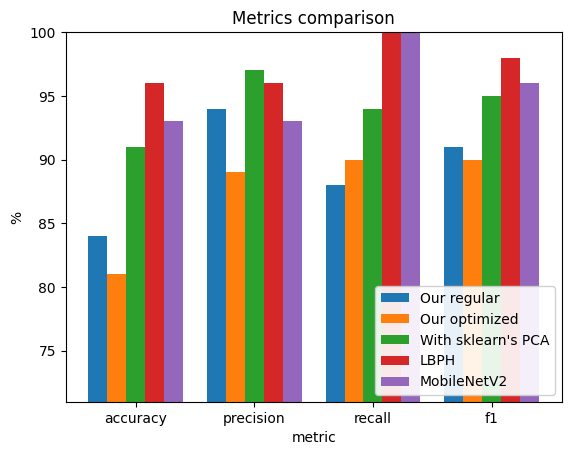

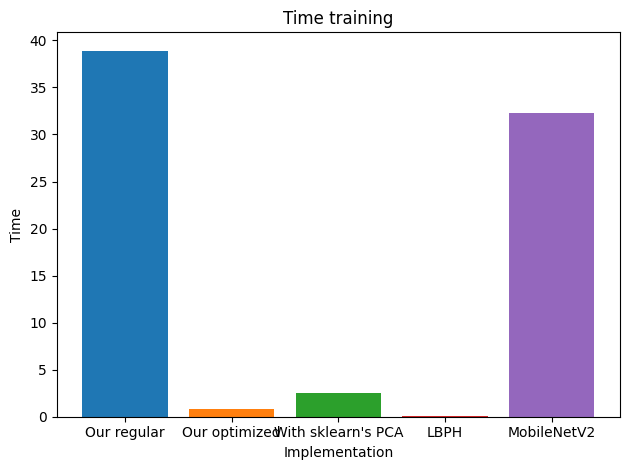

In [29]:
import matplotlib.pyplot as plt
import numpy as np

n = np.array(["accuracy", "precision", "recall", "f1"])

width = 0.35
indices = np.arange(len(n))

algorithm_metrics = [testing_metrics_regular, testing_metrics_optimized, testing_metrics_sklearn, testing_metrics_lbph, testing_metrics_neural]
algorithm_metrics = [[metric * 100 for metric in metrics] for metrics in algorithm_metrics]
labels = ['Our regular', 'Our optimized',"With sklearn's PCA", 'LBPH', 'MobileNetV2']
num_algos = len(algorithm_metrics)
width = 0.8 / num_algos

indices = np.arange(len(n))

for i, metrics in enumerate(algorithm_metrics):
    plt.bar(indices + (i - num_algos/2) * width + width/2, metrics, width=width, label=labels[i])

plt.title("Metrics comparison")

plt.xticks(indices, n)
plt.ylabel('%')
plt.xlabel("metric")
plt.ylim(bottom= max(min(min(metrics) for metrics in algorithm_metrics) - 10, 0), top=100)
# plt.legend()
plt.legend(loc='lower right', framealpha=0.9)
plt.show()
# plt.bar([1, 2, 3], [12, 23, 34], label=["1", "23", "12"])
times = [time_taken_regular, time_taken_optimized, time_taken_sklearn, time_taken_lbph, time_taken_neural]

# labels = ['A', 'B', 'C', 'D']

indices = np.arange(len(times))

for i, time in enumerate(times):
    plt.bar(indices[i], [time])
plt.xticks(indices, labels)

# for i, v in enumerate(times):
#     plt.text(i, v + 0.1, f"{v:.2f}", ha='center')

plt.title("Time training")
plt.xlabel('Implementation')
plt.ylabel('Time')
plt.tight_layout()
plt.show()


## Testing with people not from dataset

In [30]:
X_train, y_train, X_test, y_test = split_data(X, y, 0.2, 10)

dict_keys([np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31), np.int32(32), np.int32(33), np.int32(34), np.int32(35), np.int32(36), np.int32(37), np.int32(38), np.int32(39)])


### Model using sklearn PCA implementation

In [31]:
model2 = EigenfacesModelOther()
model2.train(X_train, y_train, 0.95)
testing_metrics_sklearn = model2.test(X_test, y_test)
print("accuracy: {}, precision: {}, recall: {}, f1: {}".format(*testing_metrics_sklearn))

accuracy: 0.78, precision: 0.63, recall: 0.98, f1: 0.77


### Model which uses optimization for faster computation

In [32]:
model_optimized = EigenfacesModelOptimized()

model_optimized.train(X_train, y_train, 0.95)
testing_metrics_optimized = model_optimized.test(X_test, y_test)
print("accuracy: {}, precision: {}, recall: {}, f1: {}".format(*testing_metrics_optimized))

accuracy: 0.79, precision: 0.65, recall: 0.89, f1: 0.75


### Our non-optimized model

In [33]:
model = EigenfacesModel()

model.train(X_train, y_train, 0.95)
testing_metrics_regular = model.test(X_test, y_test)
print("accuracy: {}, precision: {}, recall: {}, f1: {}".format(*testing_metrics_regular))

accuracy: 0.84, precision: 0.75, recall: 0.84, f1: 0.79


### Testing results

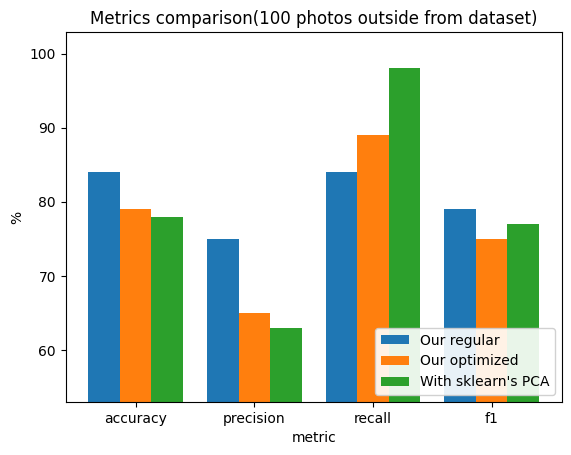

In [34]:
import matplotlib.pyplot as plt
import numpy as np

n = np.array(["accuracy", "precision", "recall", "f1"])

width = 0.35
indices = np.arange(len(n))

algorithm_metrics = [testing_metrics_regular, testing_metrics_optimized, testing_metrics_sklearn]
algorithm_metrics = [[metric * 100 for metric in metrics] for metrics in algorithm_metrics]
labels = ['Our regular', 'Our optimized',"With sklearn's PCA"]
num_algos = len(algorithm_metrics)
width = 0.8 / num_algos

indices = np.arange(len(n))

for i, metrics in enumerate(algorithm_metrics):
    plt.bar(indices + (i - num_algos/2) * width + width/2, metrics, width=width, label=labels[i])

plt.title("Metrics comparison(100 photos outside from dataset)")

plt.xticks(indices, n)
plt.ylabel('%')
plt.xlabel("metric")
plt.ylim(bottom= max(min(min(metrics) for metrics in algorithm_metrics) - 10, 0))
# plt.legend()
plt.legend(loc='lower right', framealpha=0.9)
plt.show()
